Shape of X: (768, 8)
Shape of y: (768,)
Train size: 614
Val size: 154
Epoch 001/100 | Train Loss: 0.6589 | Val Loss: 0.6567
Epoch 002/100 | Train Loss: 0.6506 | Val Loss: 0.6420
Epoch 003/100 | Train Loss: 0.6279 | Val Loss: 0.6073
Epoch 004/100 | Train Loss: 0.5883 | Val Loss: 0.5739
Epoch 005/100 | Train Loss: 0.5570 | Val Loss: 0.5546
Epoch 006/100 | Train Loss: 0.5356 | Val Loss: 0.5348
Epoch 007/100 | Train Loss: 0.5172 | Val Loss: 0.5174
Epoch 008/100 | Train Loss: 0.4961 | Val Loss: 0.5044
Epoch 009/100 | Train Loss: 0.4803 | Val Loss: 0.4979
Epoch 010/100 | Train Loss: 0.4689 | Val Loss: 0.4963
Epoch 011/100 | Train Loss: 0.4571 | Val Loss: 0.4956
Epoch 012/100 | Train Loss: 0.4504 | Val Loss: 0.4938
Epoch 013/100 | Train Loss: 0.4449 | Val Loss: 0.4926
Epoch 014/100 | Train Loss: 0.4439 | Val Loss: 0.4908
Epoch 015/100 | Train Loss: 0.4417 | Val Loss: 0.4822
Epoch 016/100 | Train Loss: 0.4360 | Val Loss: 0.4901
Epoch 017/100 | Train Loss: 0.4343 | Val Loss: 0.4905
Epoch 018/10

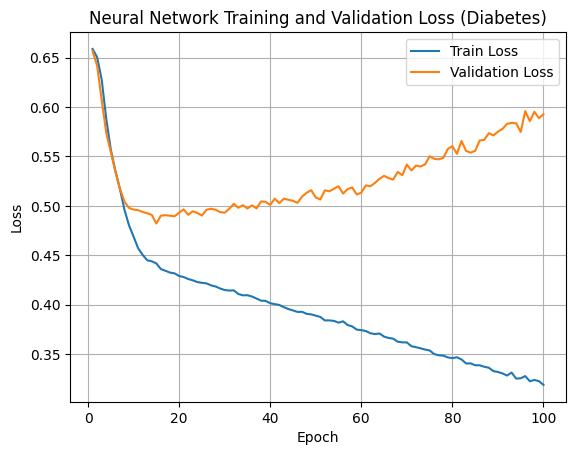


=== Neural Network Metrics (Validation Set) ===
Accuracy : 0.7143
Precision: 0.5893
Recall   : 0.6111
F1-score : 0.6000

=== Logistic Regression Metrics (Validation Set) ===
Accuracy : 0.7143
Precision: 0.6087
Recall   : 0.5185
F1-score : 0.5600

=== SVM (RBF kernel) Metrics (Validation Set) ===
Accuracy : 0.7532
Precision: 0.6600
Recall   : 0.6111
F1-score : 0.6346


===== Summary of Models on Validation Set =====
                     Accuracy  Precision    Recall        F1
Neural Network       0.714286   0.589286  0.611111  0.600000
Logistic Regression  0.714286   0.608696  0.518519  0.560000
SVM (RBF)            0.753247   0.660000  0.611111  0.634615


In [1]:
# ===========================
# Problem 1
# Mohammadmilad Sayyad_801419978
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ---------------------------
# 1. Load dataset
# ---------------------------
# If needed, change this path to where you upload the CSV in Colab
df = pd.read_csv("/content/diabetes_dataset.csv")

# Features and labels
X = df.drop("Outcome", axis=1).values.astype(np.float32)
y = df["Outcome"].values.astype(np.float32)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# ---------------------------
# 2. Train/validation split (80/20)
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape[0])
print("Val size:", X_val.shape[0])

# ---------------------------
# 3. Standardize features
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# We'll reuse X_train_scaled / X_val_scaled for all models

# ---------------------------
# 4. Fully Connected Neural Network (PyTorch)
# ---------------------------

input_dim = X_train_scaled.shape[1]

class DiabetesNet(nn.Module):
    """
    3-hidden-layer fully connected network:
    input -> 32 -> 16 -> 8 -> 1
    """
    def __init__(self, input_dim):
        super(DiabetesNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)   # output logits for binary classification
        )

    def forward(self, x):
        return self.net(x)

model = DiabetesNet(input_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoaders
batch_size = 32

train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
)
val_dataset = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 5. Training loop
# ---------------------------
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1:03d}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# ---------------------------
# 6. Plot training vs validation loss
# ---------------------------
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Neural Network Training and Validation Loss (Diabetes)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 7. Evaluation metrics function
# ---------------------------
def compute_and_print_metrics(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {model_name} Metrics (Validation Set) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    return acc, prec, rec, f1

# ---------------------------
# 8. NN metrics on validation set
# ---------------------------
model.eval()
with torch.no_grad():
    val_logits = model(torch.tensor(X_val_scaled, dtype=torch.float32))
    val_probs = torch.sigmoid(val_logits).numpy().ravel()
    y_pred_nn = (val_probs >= 0.5).astype(int)

nn_results = compute_and_print_metrics(y_val, y_pred_nn, model_name="Neural Network")

# ---------------------------
# 9. Logistic Regression baseline
# ---------------------------
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_val_scaled)

lr_results = compute_and_print_metrics(y_val, y_pred_lr, model_name="Logistic Regression")

# ---------------------------
# 10. SVM baseline
# ---------------------------
svm_clf = SVC(kernel="rbf", C=1.0, gamma="scale")  # you can tune C, gamma if you want
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_val_scaled)

svm_results = compute_and_print_metrics(y_val, y_pred_svm, model_name="SVM (RBF kernel)")

# ---------------------------
# 11. Comparison summary table (optional but useful for report)
# ---------------------------
results_df = pd.DataFrame(
    [nn_results, lr_results, svm_results],
    columns=["Accuracy", "Precision", "Recall", "F1"],
    index=["Neural Network", "Logistic Regression", "SVM (RBF)"]
)

print("\n\n===== Summary of Models on Validation Set =====")
print(results_df)
